In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

from task_5_core.lvq import LVQ 

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = list(map(lambda arr: arr.reshape(784).astype('float64'), train_images))
test_images = list(map(lambda arr: arr.reshape(784).astype('float64'), test_images))

train_data, test_data = (train_images, train_labels), (test_images, test_labels)

In [3]:
def train_and_test(train_data, test_data, pattern_split=0.01, epochs=1, alpha=0.01, learning_rule='classic'):
    model = LVQ()

    patterns_count = int(len(train_data[0]) * pattern_split)
    init_data = (train_data[0][:patterns_count], train_data[1][:patterns_count])
    fit_data = (train_data[0][patterns_count:], train_data[1][patterns_count:])
    model.train(init_data, fit_data, learning_rule, alpha, epochs)

    features, labels = test_data 
    predictions = model.predict(features)

    metrics = (
        accuracy_score(labels, predictions),
        f1_score(labels, predictions, average='macro'),
        recall_score(labels, predictions, average='macro', zero_division=0),
        precision_score(labels, predictions, average='macro', zero_division=0)
    )
    return metrics

In [4]:
pattern_split_options = [0.0001, 0.001, 0.0025]
epochs_options = [1, 2, 5]
alpha_options = [0.001, 0.01, 0.05]
learning_rules = ['classic', 'two_step']
options = set(itertools.product(pattern_split_options, epochs_options, alpha_options, learning_rules))

def pattern_split_metrics():
    return {pattern_split: {} for pattern_split in pattern_split_options}

def epochs_metrics(): 
    return {epochs: pattern_split_metrics() for epochs in epochs_options}

def alpha_metrics():
    return {alpha: epochs_metrics() for alpha in alpha_options}

history = {rule: alpha_metrics() for rule in learning_rules}

for pattern_split, epochs, alpha, learning_rule in options:
    metrics = train_and_test(train_data, test_data, pattern_split=pattern_split, epochs=epochs, alpha=alpha, learning_rule=learning_rule)
    history[learning_rule][alpha][epochs][pattern_split] = metrics

d:\conda\envs\anns3.9\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\ХНУРЕ\шнмз\python_neural_nets\tasks\task_5_core\lvq.py:8: RuntimeWarning: overflow encountered in square
  return np.sqrt(np.sum(np.square(first - second), axis=1))
d:\ХНУРЕ\шнмз\python_neural_nets\tasks\task_5_core\lvq.py:44: RuntimeWarning: overflow encountered in subtract
  bmu_w -= error * self.alpha
d:\ХНУРЕ\шнмз\python_neural_nets\tasks\task_5_core\lvq.py:42: RuntimeWarning: invalid value encountered in add
  bmu_w += error * self.alpha
d:\conda\envs\anns3.9\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\conda\envs\anns3.9\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\conda\envs\anns3.9\

rule: classic, alpha: 0.001
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9243, 0.9235163985368768, 0.9233135202693529, 0.9244779240235305)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.1032, 0.018709209572153735, 0.1, 0.01032), 0.001: (0.8989, 0.8977241335004502, 0.8973163348032374, 0.9005127795400576), 0.0025: (0.9274, 0.926616382319286, 0.9264327183912175, 0.9274230717626535)}


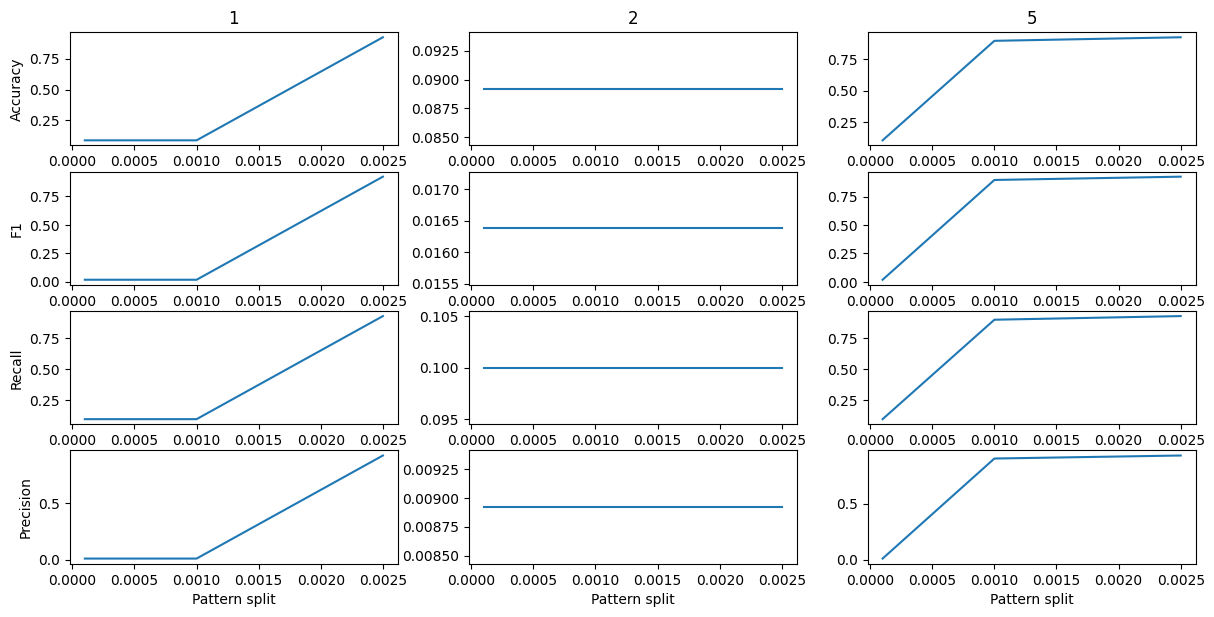

rule: classic, alpha: 0.01
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8953, 0.894189922140843, 0.8938268773668648, 0.8973296196674051), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.1009, 0.0183304568989009, 0.1, 0.01009), 0.001: (0.8932, 0.8918568992990427, 0.891340551164736, 0.895549016023385), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9286, 0.9278182768491965, 0.9277742366043797, 0.928419845302888)}


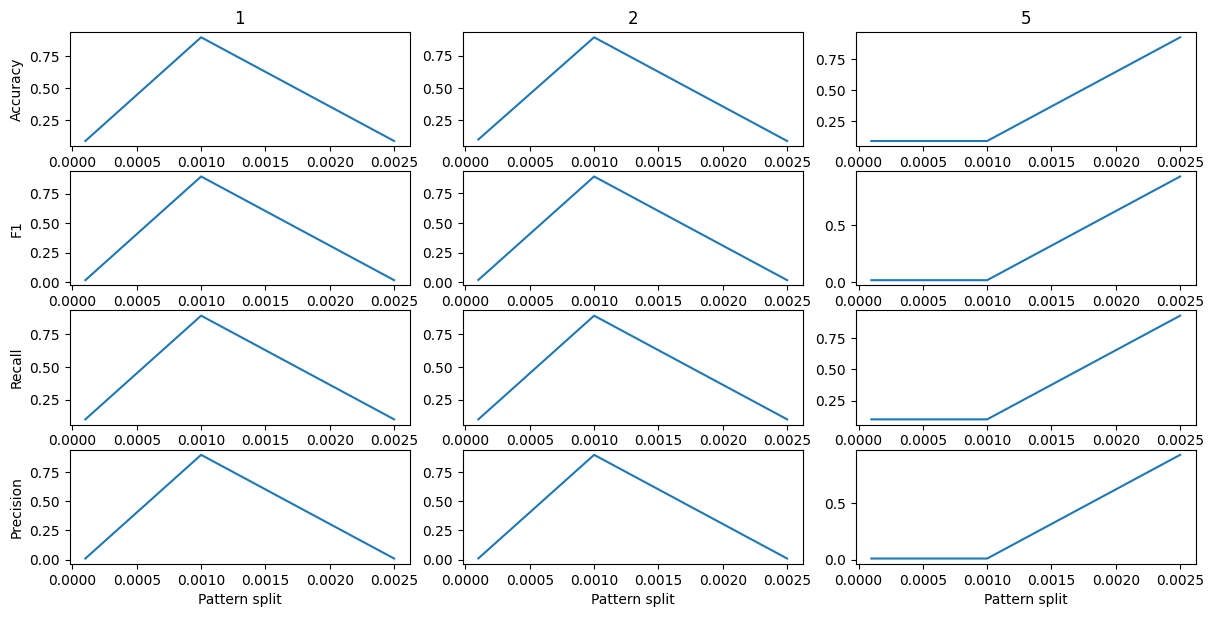

rule: classic, alpha: 0.05
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9134, 0.9124042582695239, 0.9120554763079035, 0.9142405115007268)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9152, 0.9144324852613044, 0.9140383858812549, 0.9162692025997984)}


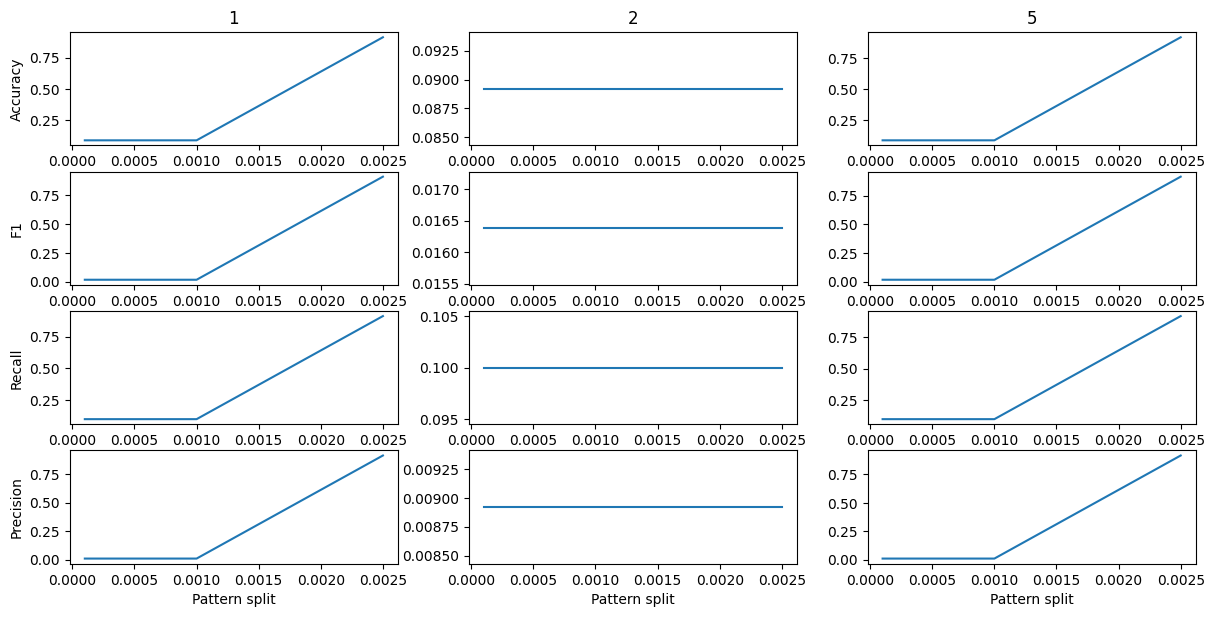

rule: two_step, alpha: 0.001
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8748, 0.8744347890201322, 0.8732752528837275, 0.8826909654022067), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.4451, 0.38707366169304364, 0.4417197949510264, 0.4008614086066184), 0.001: (0.8814, 0.880754055026013, 0.8801931082171794, 0.8877975619110859), 0.0025: (0.9139, 0.9129311393081977, 0.9131434237504557, 0.9149895493444001)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9237, 0.9226990888113654, 0.9228281067943126, 0.9241725115413857)}


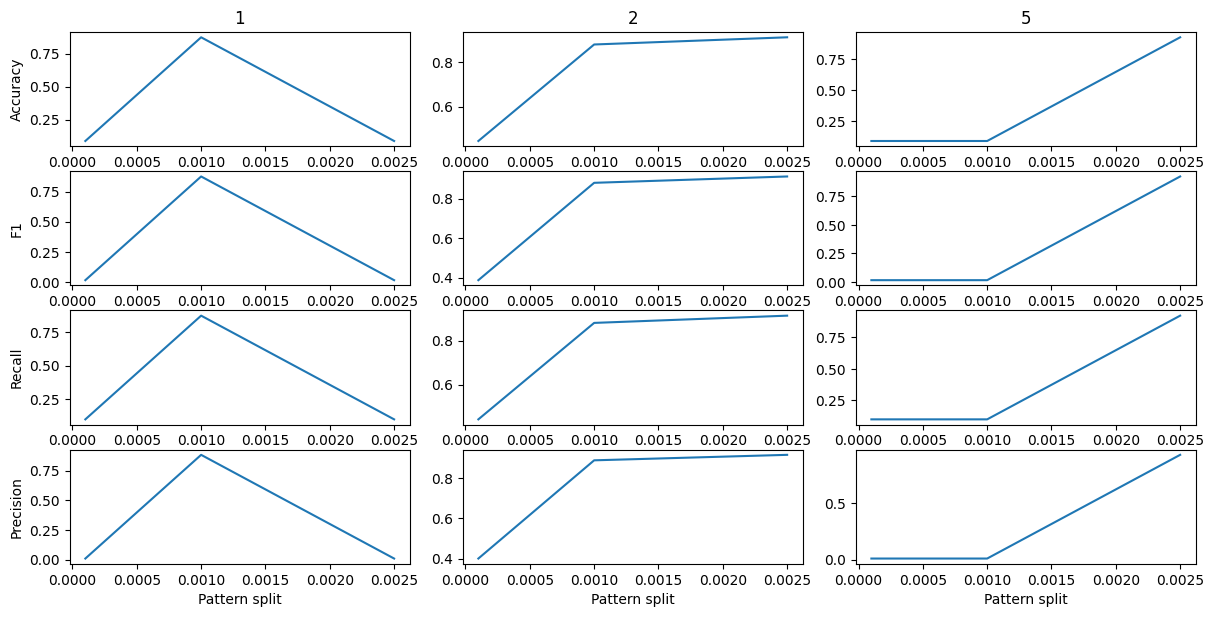

rule: two_step, alpha: 0.01
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8815, 0.8804753782449876, 0.8798470996318051, 0.8868718434395764), 0.0025: (0.9178, 0.9166855424339161, 0.9168882035011217, 0.9180034211946208)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8787, 0.8775780583647792, 0.8769960585361671, 0.8841450092961877), 0.0025: (0.9216, 0.9205889167537908, 0.9207827670559382, 0.922045015129819)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8788, 0.8777759210422496, 0.8771745412914779, 0.8844741573905994), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}


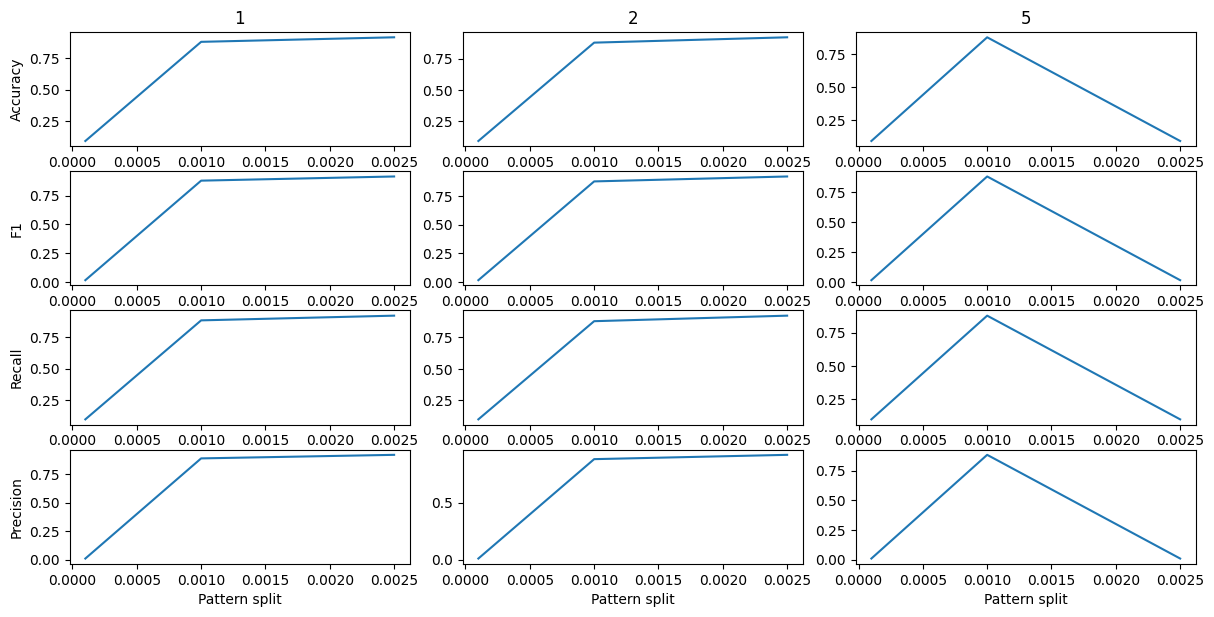

rule: two_step, alpha: 0.05
{0.0001: (0.4105, 0.3524572580316415, 0.4106007203893392, 0.3602445111509297), 0.001: (0.8336, 0.8310137326903628, 0.8310237813307804, 0.8477725259042279), 0.0025: (0.0892, 0.01637899375688579, 0.1, 0.00892)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.8464, 0.8442517290418815, 0.8439076740785755, 0.8551892200769438), 0.0025: (0.9086, 0.9072501889161451, 0.9072699739027904, 0.9089465140386904)}
{0.0001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.001: (0.0892, 0.01637899375688579, 0.1, 0.00892), 0.0025: (0.9145, 0.9132048005786219, 0.9133282867545706, 0.9144471331259846)}


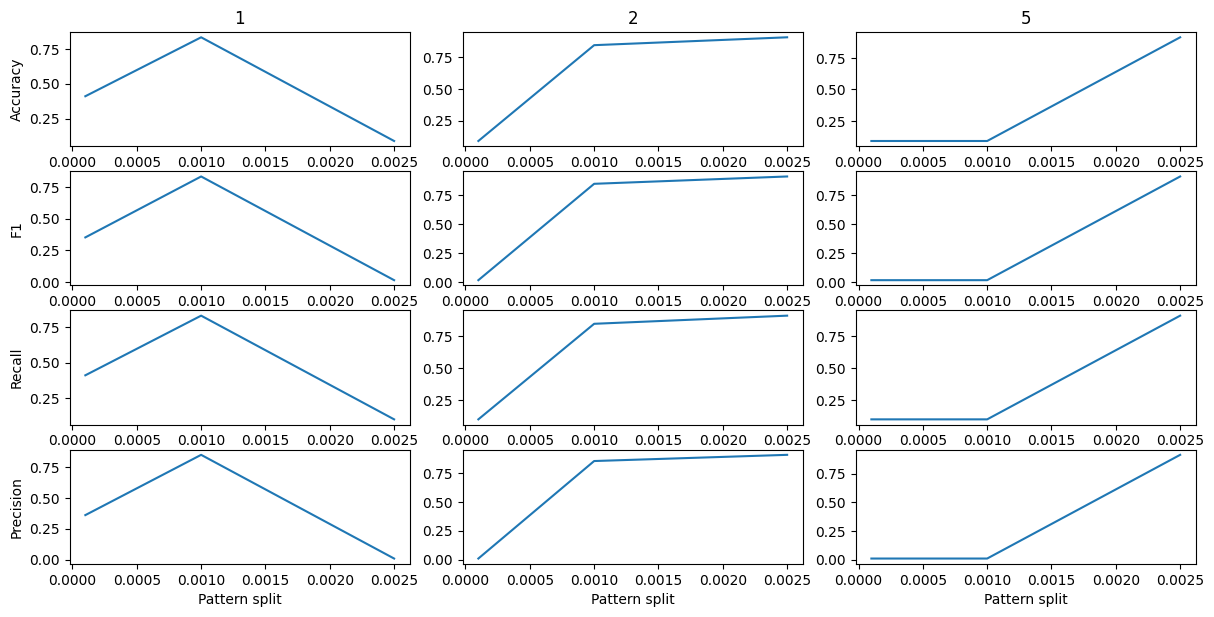

In [10]:
def visualize_dict_metrics(history):
    metric_names = ['Accuracy', 'F1', 'Recall', 'Precision']
    
    for rule, alphas_dict in history.items():
        for alpha, epochs_dict in alphas_dict.items():
            print(f'rule: {rule}, alpha: {alpha}')
            fig = plt.figure(figsize=(12, 6))

            for epochs, metrics in epochs_dict.items(): 
                offset = list(epochs_dict.keys()).index(epochs)
                print(metrics)

                plt.subplot(4, 3, 1 + offset)
                plt.plot(metrics.keys(), [metric[0] for metric in metrics.values()], label=f'{alpha} - {metric_names[0]}')
                plt.title(f'{epochs}')
                if offset == 0:
                    plt.ylabel(metric_names[0])

                plt.subplot(4, 3, 4 + offset)
                plt.plot(metrics.keys(), [metric[1] for metric in metrics.values()], label=f'{alpha} - {metric_names[1]}')
                if offset == 0:
                    plt.ylabel(metric_names[1])

                plt.subplot(4, 3, 7 + offset)
                plt.plot(metrics.keys(), [metric[2] for metric in metrics.values()], label=f'{alpha} - {metric_names[2]}')
                if offset == 0:
                    plt.ylabel(metric_names[2])

                plt.subplot(4, 3, 10 + offset)
                plt.plot(metrics.keys(), [metric[3] for metric in metrics.values()], label=f'{alpha} - {metric_names[3]}')
                if offset == 0:
                    plt.ylabel(metric_names[3])
                plt.xlabel('Pattern split')

            fig.tight_layout(pad=0.1)
            plt.show()


visualize_dict_metrics(history)